In [1]:
import pandas as pd

import lifelines
from lifelines.utils import to_long_format
from lifelines.utils import add_covariate_to_timeline
from lifelines import CoxTimeVaryingFitter

from scipy.stats import wilcoxon, friedmanchisquare, kruskal

import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

sns.set(rc={"figure.figsize": (5, 5)})
sns.set_style("ticks")

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
boxplot_props = {
    "boxprops": {"facecolor": "none", "edgecolor": (0.25, 0.25, 0.25)},
    "medianprops": {"color": (0.25, 0.25, 0.25)},
    "whiskerprops": {"color": (0.25, 0.25, 0.25)},
    "capprops": {"color": (0.25, 0.25, 0.25)},
}

# UTSW retrospective cohort

In [3]:
emboli_data = pd.read_excel("data/Supplementary Table 3.xlsx")

In [4]:
emboli_data["Medium_Large_Art"] = emboli_data["Medium_Art"] + emboli_data["Large_Art"]
emboli_data["Medium_Large_Vein"] = (
    emboli_data["Medium_Vein"] + emboli_data["Large_Vein"]
)

emboli_data = emboli_data.drop(
    columns=["Medium_Art", "Large_Art", "Medium_Vein", "Large_Vein"]
)

In [5]:
pt_emboli_data = emboli_data.groupby(["Patient_ID"]).sum().reset_index()

In [6]:
vals = []
labs = []
hues = []

vars_ = [
    "Medium_Large_Art",
    "Small_Art",
    "Medium_Large_Vein",
    "Small_Vein",
]
var_labels = [
    "Medium/Large Artery",
    "Small Artery",
    "Medium/Large Vein",
    "Small Vein",
]
hue_categories = ["Artery", "Artery", "Vein", "Vein"]

for row in pt_emboli_data.iterrows():
    for var, var_label, hue_cat in zip(vars_, var_labels, hue_categories):
        vals.append(row[1][var])
        labs.append(var_label)
        hues.append(hue_cat)

vals = np.array(vals)

In [7]:
size_classes = ["Medium_Large", "Small", "Medium_Large", "Small"]
vessel_classes = ["Artery", "Artery", "Vein", "Vein"]

all_pts = list(set(emboli_data["Patient_ID"]))

dists = [[0, 0, 0, 0] for _pt in all_pts]

for row in emboli_data.iterrows():
    this_pt = row[1]["Patient_ID"]
    dists_idx = all_pts.index(this_pt)

    for idx, var in enumerate(vars_):
        if not pd.isnull(row[1][var]):
            dists[dists_idx][idx] += row[1][var]

dists = np.array(dists).T

friedman_res = friedmanchisquare(*dists)

In [8]:
pairwise_wilcoxon_results = []

for idx_0 in range(len(vars_) - 1):
    var_0 = vars_[idx_0]

    for idx_1 in range(idx_0 + 1, len(vars_)):
        var_1 = vars_[idx_1]

        delta = dists[idx_1] - dists[idx_0]
        n_pts_w_increase = len([it for it in delta if it > 0])

        res = wilcoxon(delta, alternative="two-sided")
        pairwise_wilcoxon_results.append(
            (
                var_0,
                var_1,
                res.pvalue,
                np.median(delta),
                np.mean(delta),
                n_pts_w_increase,
            )
        )

In [9]:
vals += 1
vals = np.log10(vals)

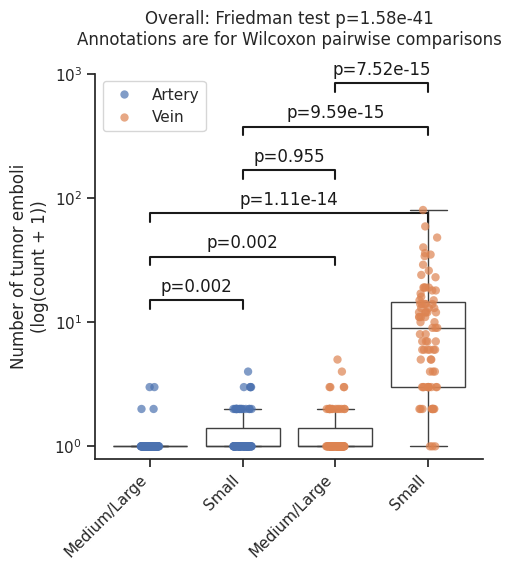

In [10]:
p = sns.boxplot(
    x=labs, y=vals, saturation=0.8, color="white", fliersize=0, **boxplot_props
)
b = sns.stripplot(
    x=labs,
    y=vals,
    alpha=0.7,
    hue=hues,
    size=6,
)

_ = plt.ylabel("Number of tumor emboli\n(log(count + 1))")


############## anns
ylim = plt.ylim()

stat_annotations_y_start = ylim[0] + (ylim[1] - ylim[0]) / 2.5
stat_annotations_y_start *= 1.4
height = (ylim[1] - ylim[0]) / 6

height_adj_idx = 0

for (
    var_0,
    var_1,
    pval,
    _median_delta,
    _mean_delta,
    _n_pts_w_increase,
) in pairwise_wilcoxon_results:
    if pval < 0.0005:
        pval = f"p={pval:.2e}"
    else:
        pval = f"p={pval:.3f}"
    x1, x2 = vars_.index(var_0), vars_.index(var_1)

    y = stat_annotations_y_start + height * height_adj_idx
    h = (ylim[1] - ylim[0]) / 30

    plt.plot([x1, x1, x2, x2], [y + h, y + (2 * h), y + (2 * h), y + h], lw=1.5, c="k")
    plt.text((x1 + x2) * 0.5, y + (2.5 * h), pval, ha="center", va="bottom", color="k")

    height_adj_idx += 1

#########################

# set y tick labels
_ = plt.yticks(
    [0, 1, 2, 3],
)

_ = p.set_ylim(-0.1, 3)
_ = p.set_yticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$"])

xticklabels = p.get_xticklabels()
xticklabels = [" ".join(it.get_text().split()[:-1]) for it in xticklabels]

_ = p.set_xticks(np.arange(len(xticklabels)))
_ = p.set_xticklabels(xticklabels, rotation=45, ha="right")

_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

_ = plt.title(
    f"Overall: Friedman test p={friedman_res.pvalue:.2e}\n"
    f"Annotations are for Wilcoxon pairwise comparisons\n"
)

# UTSW prospective cohort

In [11]:
utsw_prospective_df = pd.read_excel("data/Supplementary Table 7.xlsx")

In [12]:
premortem_data = {}
postmortem_data = {}

for _idx, row in utsw_prospective_df.iterrows():
    if row["Cohort"] == "Control":
        continue

    pt = row["Patient"]
    visit = row["Visit"]

    if visit == "Post-Mortem":
        postmortem_data[pt] = {
            "Total CTCs": row["Total FITC+ CTCs (count/ml)"],
            "CTC cluster size": row["Mean CTC cluster size: overall"],
            "Total CTC clusters": row["Total FITC+ CTC clusters (count/ml)"],
            "Single CTCs": row["Single FITC+ CTCs (count/ml)"],
            "Homotypic clusters": row["Homotypic FITC+ CTC clusters (count/ml)"],
            "Heterotypic clusters": row["Heterotypic FITC+ CTC clusters (count/ml)"],
        }
    else:
        if pt not in premortem_data:
            premortem_data[pt] = []

        premortem_data[pt].append(
            {
                "visit": visit,
                "Total CTCs": row["Total FITC+ CTCs (count/ml)"],
                "CTC cluster size": row["Mean CTC cluster size"],
                "Total CTC clusters": row["Total FITC+ CTC clusters (count/ml)"],
                "Single CTCs": row["Single FITC+ CTCs (count/ml)"],
                "Homotypic clusters": row["Homotypic FITC+ CTC clusters (count/ml)"],
                "Heterotypic clusters": row[
                    "Heterotypic FITC+ CTC clusters (count/ml)"
                ],
            }
        )

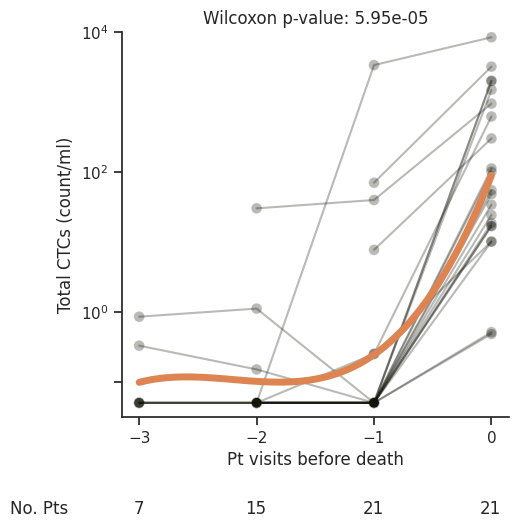

In [13]:
x = []
y = []
labs = []

test_vector = []
var = "Total CTCs"

for pt in premortem_data:
    this_ctc_data = [it for it in premortem_data[pt] if not pd.isnull(it[var])]
    this_ctc_data = sorted(this_ctc_data, key=lambda it: it["visit"])

    for idx, data_dict in enumerate(this_ctc_data):
        timepoint = -1 * (len(this_ctc_data) - idx)

        # we are only visualizing timepoints -3 to 0 in these plots, but you will notice that
        # the test vector uses the first available timepoint. In any case, this would only
        # potentially affect a single case and would have no effect on outcome
        if timepoint > -4:
            x.append(timepoint)
            y.append(data_dict[var])
            labs.append(pt)

    postmortem_val = postmortem_data[pt][var]

    if not pd.isnull(postmortem_val):
        x.append(0)
        y.append(postmortem_val)
        labs.append(pt)

        test_vector.append(postmortem_val - this_ctc_data[0][var])

wilcoxon_res = wilcoxon(test_vector, alternative="two-sided")

# pad 0 values for visualization in log scale
y = np.array(y) + 0.05
y = np.log10(y)

pal = sns.color_palette([f"#14140a" for _ in range(len(premortem_data))])

p = sns.lineplot(x=x, y=y, hue=labs, palette=pal, alpha=0.298)

c = sns.scatterplot(x=x, y=y, hue=labs, alpha=0.298, s=60, legend=False, palette=pal)

d = sns.regplot(
    x=x, y=y, scatter=False, ci=None, order=3, line_kws={"linewidth": 5}, ax=plt.gca()
)

_ = plt.yticks(
    [-1, 0, 2, 4],
)

# set y tick labels
_ = p.set_yticklabels(["", "$10^0$", "$10^2$", "$10^4$"])

_ = plt.ylim(-1.5, 4)
_ = plt.xticks([-3, -2, -1, 0])

# remove legend
_ = plt.legend([], [], frameon=False)

_ = plt.xlabel("Pt visits before death")
_ = plt.ylabel("Total CTCs (count/ml)")

ylim = plt.ylim()
counts_y = ylim[0] - (ylim[1] - ylim[0]) * 0.25

_ = plt.text(
    -4.1,
    counts_y,
    "No. Pts",
)
_ = plt.text(
    -3.05,
    counts_y,
    str(len([it for it in x if it == -3])),
)
_ = plt.text(
    -2.1,
    counts_y,
    str(len([it for it in x if it == -2])),
)
_ = plt.text(
    -1.1,
    counts_y,
    str(len([it for it in x if it == -1])),
)
_ = plt.text(
    -0.1,
    counts_y,
    str(len([it for it in x if it == 0])),
)

_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

_ = plt.title(f"Wilcoxon p-value: {wilcoxon_res.pvalue:.2e}")

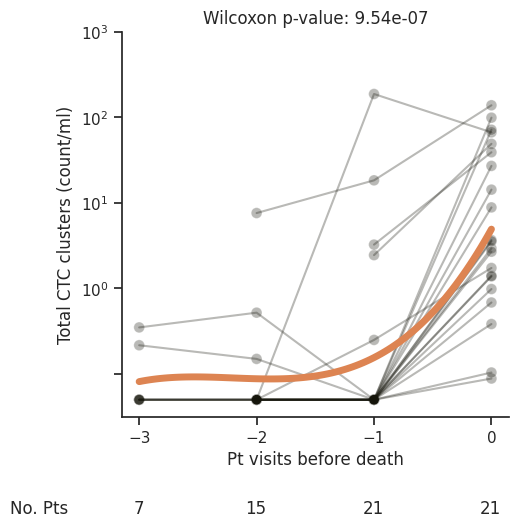

In [14]:
x = []
y = []
labs = []

test_vector = []
var = "Total CTC clusters"

for pt in premortem_data:
    this_ctc_data = [it for it in premortem_data[pt] if not pd.isnull(it[var])]
    this_ctc_data = sorted(this_ctc_data, key=lambda it: it["visit"])

    for idx, data_dict in enumerate(this_ctc_data):
        timepoint = -1 * (len(this_ctc_data) - idx)

        if timepoint > -4:
            x.append(timepoint)
            y.append(data_dict[var])
            labs.append(pt)

    postmortem_val = postmortem_data[pt][var]

    if not pd.isnull(postmortem_val):
        x.append(0)
        y.append(postmortem_val)
        labs.append(pt)

        test_vector.append(postmortem_val - this_ctc_data[0][var])

wilcoxon_res = wilcoxon(test_vector, alternative="two-sided")

# pad 0 values for visualization in log scale
y = np.array(y) + 0.05
y = np.log10(y)

pal = sns.color_palette([f"#14140a" for _ in range(len(premortem_data))])

p = sns.lineplot(x=x, y=y, hue=labs, palette=pal, alpha=0.298)

c = sns.scatterplot(x=x, y=y, hue=labs, alpha=0.298, s=60, legend=False, palette=pal)

d = sns.regplot(
    x=x, y=y, scatter=False, ci=None, order=3, line_kws={"linewidth": 5}, ax=plt.gca()
)

_ = plt.yticks(
    [-1, 0, 1, 2, 3],
)

# set y tick labels
_ = p.set_yticklabels(["", "$10^0$", "$10^1$", "$10^2$", "$10^3$"])

_ = plt.ylim(-1.5, 3)

_ = plt.xticks([-3, -2, -1, 0])

# remove legend
_ = plt.legend([], [], frameon=False)

_ = plt.xlabel("Pt visits before death")
_ = plt.ylabel("Total CTC clusters (count/ml)")

ylim = plt.ylim()
counts_y = ylim[0] - (ylim[1] - ylim[0]) * 0.25

_ = plt.text(
    -4.1,
    counts_y,
    "No. Pts",
)
_ = plt.text(
    -3.05,
    counts_y,
    str(len([it for it in x if it == -3])),
)
_ = plt.text(
    -2.1,
    counts_y,
    str(len([it for it in x if it == -2])),
)
_ = plt.text(
    -1.1,
    counts_y,
    str(len([it for it in x if it == -1])),
)
_ = plt.text(
    -0.1,
    counts_y,
    str(len([it for it in x if it == 0])),
)

_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

_ = plt.title(f"Wilcoxon p-value: {wilcoxon_res.pvalue:.2e}")

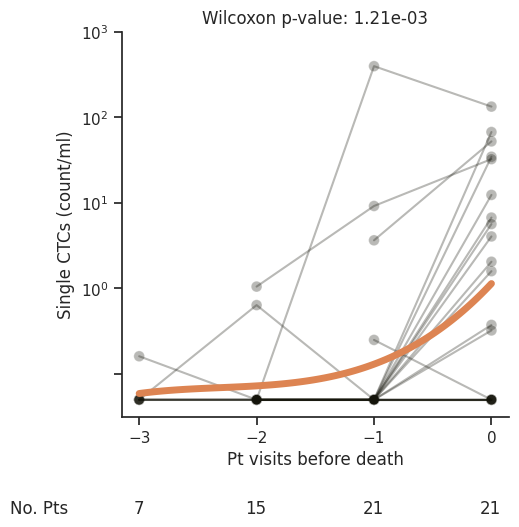

In [15]:
x = []
y = []
labs = []

test_vector = []
var = "Single CTCs"

for pt in premortem_data:
    this_ctc_data = [it for it in premortem_data[pt] if not pd.isnull(it[var])]
    this_ctc_data = sorted(this_ctc_data, key=lambda it: it["visit"])

    for idx, data_dict in enumerate(this_ctc_data):
        timepoint = -1 * (len(this_ctc_data) - idx)

        if timepoint > -4:
            x.append(timepoint)
            y.append(data_dict[var])
            labs.append(pt)

    postmortem_val = postmortem_data[pt][var]

    if not pd.isnull(postmortem_val):
        x.append(0)
        y.append(postmortem_val)
        labs.append(pt)

        test_vector.append(postmortem_val - this_ctc_data[0][var])

wilcoxon_res = wilcoxon(test_vector, alternative="two-sided")

# pad 0 values for visualization in log scale
y = np.array(y) + 0.05
y = np.log10(y)

pal = sns.color_palette([f"#14140a" for _ in range(len(premortem_data))])

p = sns.lineplot(x=x, y=y, hue=labs, palette=pal, alpha=0.298)

c = sns.scatterplot(x=x, y=y, hue=labs, alpha=0.298, s=60, legend=False, palette=pal)

d = sns.regplot(
    x=x, y=y, scatter=False, ci=None, order=3, line_kws={"linewidth": 5}, ax=plt.gca()
)

_ = plt.yticks(
    [-1, 0, 1, 2, 3],
)

# set y tick labels
_ = p.set_yticklabels(["", "$10^0$", "$10^1$", "$10^2$", "$10^3$"])

_ = plt.ylim(-1.5, 3)

_ = plt.xticks([-3, -2, -1, 0])

# remove legend
_ = plt.legend([], [], frameon=False)

_ = plt.xlabel("Pt visits before death")
_ = plt.ylabel("Single CTCs (count/ml)")

ylim = plt.ylim()
counts_y = ylim[0] - (ylim[1] - ylim[0]) * 0.25

_ = plt.text(
    -4.1,
    counts_y,
    "No. Pts",
)
_ = plt.text(
    -3.05,
    counts_y,
    str(len([it for it in x if it == -3])),
)
_ = plt.text(
    -2.1,
    counts_y,
    str(len([it for it in x if it == -2])),
)
_ = plt.text(
    -1.1,
    counts_y,
    str(len([it for it in x if it == -1])),
)
_ = plt.text(
    -0.1,
    counts_y,
    str(len([it for it in x if it == 0])),
)

_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

_ = plt.title(f"Wilcoxon p-value: {wilcoxon_res.pvalue:.2e}")

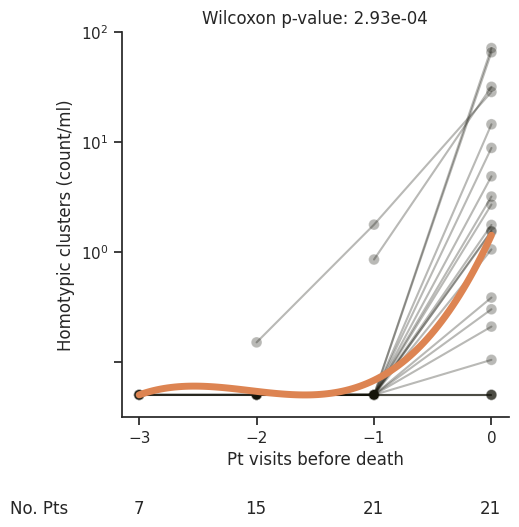

In [16]:
x = []
y = []
labs = []

test_vector = []
var = "Homotypic clusters"

for pt in premortem_data:
    this_ctc_data = [it for it in premortem_data[pt] if not pd.isnull(it[var])]
    this_ctc_data = sorted(this_ctc_data, key=lambda it: it["visit"])

    for idx, data_dict in enumerate(this_ctc_data):
        timepoint = -1 * (len(this_ctc_data) - idx)

        if timepoint > -4:
            x.append(timepoint)
            y.append(data_dict[var])
            labs.append(pt)

    postmortem_val = postmortem_data[pt][var]

    if not pd.isnull(postmortem_val):
        x.append(0)
        y.append(postmortem_val)
        labs.append(pt)

        test_vector.append(postmortem_val - this_ctc_data[0][var])

wilcoxon_res = wilcoxon(test_vector, alternative="two-sided")

# pad 0 values for visualization in log scale
y = np.array(y) + 0.05
y = np.log10(y)

pal = sns.color_palette([f"#14140a" for _ in range(len(premortem_data))])

p = sns.lineplot(x=x, y=y, hue=labs, palette=pal, alpha=0.298)

c = sns.scatterplot(x=x, y=y, hue=labs, alpha=0.298, s=60, legend=False, palette=pal)

d = sns.regplot(
    x=x, y=y, scatter=False, ci=None, order=3, line_kws={"linewidth": 5}, ax=plt.gca()
)

_ = plt.yticks(
    [
        -1,
        0,
        1,
        2,
    ],
)

# set y tick labels
_ = p.set_yticklabels(
    [
        "",
        "$10^0$",
        "$10^1$",
        "$10^2$",
    ]
)

_ = plt.ylim(-1.5, 2)

_ = plt.xticks([-3, -2, -1, 0])

# remove legend
_ = plt.legend([], [], frameon=False)

_ = plt.xlabel("Pt visits before death")
_ = plt.ylabel(f"{var} (count/ml)")

ylim = plt.ylim()
counts_y = ylim[0] - (ylim[1] - ylim[0]) * 0.25

_ = plt.text(
    -4.1,
    counts_y,
    "No. Pts",
)
_ = plt.text(
    -3.05,
    counts_y,
    str(len([it for it in x if it == -3])),
)
_ = plt.text(
    -2.1,
    counts_y,
    str(len([it for it in x if it == -2])),
)
_ = plt.text(
    -1.1,
    counts_y,
    str(len([it for it in x if it == -1])),
)
_ = plt.text(
    -0.1,
    counts_y,
    str(len([it for it in x if it == 0])),
)

_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

_ = plt.title(f"Wilcoxon p-value: {wilcoxon_res.pvalue:.2e}")

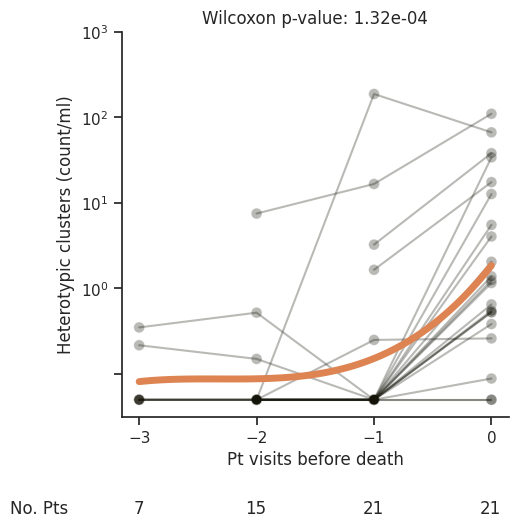

In [17]:
x = []
y = []
labs = []

test_vector = []
var = "Heterotypic clusters"

for pt in premortem_data:
    this_ctc_data = [it for it in premortem_data[pt] if not pd.isnull(it[var])]
    this_ctc_data = sorted(this_ctc_data, key=lambda it: it["visit"])

    for idx, data_dict in enumerate(this_ctc_data):
        timepoint = -1 * (len(this_ctc_data) - idx)

        if timepoint > -4:
            x.append(timepoint)
            y.append(data_dict[var])
            labs.append(pt)

    postmortem_val = postmortem_data[pt][var]

    if not pd.isnull(postmortem_val):
        x.append(0)
        y.append(postmortem_val)
        labs.append(pt)

        test_vector.append(postmortem_val - this_ctc_data[0][var])

wilcoxon_res = wilcoxon(test_vector, alternative="two-sided")

# pad 0 values for visualization in log scale
y = np.array(y) + 0.05
y = np.log10(y)

pal = sns.color_palette([f"#14140a" for _ in range(len(premortem_data))])

p = sns.lineplot(x=x, y=y, hue=labs, palette=pal, alpha=0.298)

c = sns.scatterplot(x=x, y=y, hue=labs, alpha=0.298, s=60, legend=False, palette=pal)

d = sns.regplot(
    x=x, y=y, scatter=False, ci=None, order=3, line_kws={"linewidth": 5}, ax=plt.gca()
)

_ = plt.yticks(
    [-1, 0, 1, 2, 3],
)

# set y tick labels
_ = p.set_yticklabels(["", "$10^0$", "$10^1$", "$10^2$", "$10^3$"])

_ = plt.ylim(-1.5, 3)

_ = plt.xticks([-3, -2, -1, 0])

# remove legend
_ = plt.legend([], [], frameon=False)

_ = plt.xlabel("Pt visits before death")
_ = plt.ylabel(f"{var} (count/ml)")

ylim = plt.ylim()
counts_y = ylim[0] - (ylim[1] - ylim[0]) * 0.25

_ = plt.text(
    -4.1,
    counts_y,
    "No. Pts",
)
_ = plt.text(
    -3.05,
    counts_y,
    str(len([it for it in x if it == -3])),
)
_ = plt.text(
    -2.1,
    counts_y,
    str(len([it for it in x if it == -2])),
)
_ = plt.text(
    -1.1,
    counts_y,
    str(len([it for it in x if it == -1])),
)
_ = plt.text(
    -0.1,
    counts_y,
    str(len([it for it in x if it == 0])),
)

_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

_ = plt.title(f"Wilcoxon p-value: {wilcoxon_res.pvalue:.2e}")

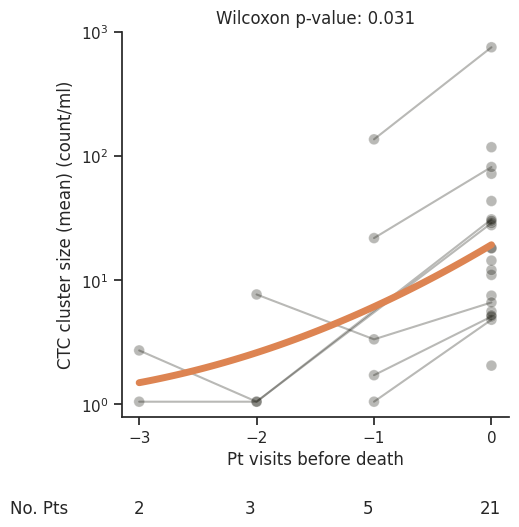

In [18]:
x = []
y = []
labs = []

test_vector = []
var = "CTC cluster size"

for pt in premortem_data:
    this_ctc_data = sorted(premortem_data[pt], key=lambda it: it["visit"])
    premortem_vals = []

    for idx, data_dict in enumerate(this_ctc_data):
        timepoint = -1 * (len(this_ctc_data) - idx)

        if timepoint > -4 and not pd.isnull(data_dict[var]):
            x.append(timepoint)
            y.append(data_dict[var])
            labs.append(pt)

            premortem_vals.append(data_dict[var])

    postmortem_val = postmortem_data[pt][var]

    if not pd.isnull(postmortem_val):
        x.append(0)
        y.append(postmortem_val)
        labs.append(pt)

        if len(this_ctc_data) > 0 and len(premortem_vals) > 0:
            test_vector.append(postmortem_val - premortem_vals[0])

wilcoxon_res = wilcoxon(test_vector, alternative="two-sided")

# pad 0 values for visualization in log scale
y = np.array(y) + 0.05
y = np.log10(y)

pal = sns.color_palette([f"#14140a" for _ in range(len(premortem_data))])

p = sns.lineplot(x=x, y=y, hue=labs, palette=pal, alpha=0.298)

c = sns.scatterplot(x=x, y=y, hue=labs, alpha=0.298, s=60, legend=False, palette=pal)

d = sns.regplot(
    x=x, y=y, scatter=False, ci=None, order=2, line_kws={"linewidth": 5}, ax=plt.gca()
)

_ = plt.yticks(
    [0, 1, 2, 3],
)

# set y tick labels
_ = p.set_yticklabels(
    [
        "$10^0$",
        "$10^1$",
        "$10^2$",
        "$10^3$",
    ]
)

_ = plt.ylim(-0.1, 3)
_ = plt.xticks([-3, -2, -1, 0])

# remove legend
_ = plt.legend([], [], frameon=False)

_ = plt.xlabel("Pt visits before death")
_ = plt.ylabel("CTC cluster size (mean) (count/ml)")

ylim = plt.ylim()
counts_y = ylim[0] - (ylim[1] - ylim[0]) * 0.25

_ = plt.text(
    -4.1,
    counts_y,
    "No. Pts",
)
_ = plt.text(
    -3.05,
    counts_y,
    str(len([it for it in x if it == -3])),
)
_ = plt.text(
    -2.1,
    counts_y,
    str(len([it for it in x if it == -2])),
)
_ = plt.text(
    -1.1,
    counts_y,
    str(len([it for it in x if it == -1])),
)
_ = plt.text(
    -0.1,
    counts_y,
    str(len([it for it in x if it == 0])),
)

_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

_ = plt.title(f"Wilcoxon p-value: {wilcoxon_res.pvalue:.3f}")

# German retrospective cohort

## Survival analyses
Logic for the time-varying covariate Cox regression is based on the [`lifelines` documentation](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html).

In [19]:
german_df = pd.read_excel("data/Supplementary Table 11.xlsx")

In [20]:
data = []

# i do this because i don't enjoy pandas
for idx, row in german_df.iterrows():
    vital_status = row["Vital status"]

    if vital_status == "Alive":
        vital_status = 0
    elif vital_status == "Deceased":
        vital_status = 1
    else:
        raise ValueError(f"Unexpected vital status: {vital_status}")

    sex = 0

    if row["Sex"] == "M":
        sex = 1

    vessel_times = []

    for vessel in range(1, 5):
        vessel_col = f"Vessel {vessel} involvement"

        if row[vessel_col] == 1:
            imaging_time_cols = []

            for imaging_idx in range(1, 10):
                this_imaging_time_col = f"Vessel {vessel} Imaging time {imaging_idx} time to involvement (days)"
                if this_imaging_time_col in row:
                    imaging_time_cols.append(this_imaging_time_col)

            final_imaging_time_col = (
                f"Vessel {vessel} LAST AVAILABLE STUDY time to involvement (days)"
            )

            if final_imaging_time_col in row:
                imaging_time_cols.append(final_imaging_time_col)

            involvement_times = [
                row[it] for it in imaging_time_cols if pd.notnull(row[it])
            ]
            earliest_involvement = min(involvement_times)

            vessel_times.append((row[f"Vessel {vessel} type"], earliest_involvement))

    earliest_vessel = None

    if len(vessel_times) > 0:
        min_time = min([it[1] for it in vessel_times])
        earliest_vessel = [it[0] for it in vessel_times if it[1] == min_time]
        earliest_vessel = [str(it) for it in earliest_vessel]

        if len(earliest_vessel) > 1:
            earliest_vessel = " + ".join(sorted(earliest_vessel))
        else:
            earliest_vessel = earliest_vessel[0]

    data.append(
        {
            "pt": row["Censored ID"],
            "age": row["Age"],
            "sex": sex,
            "status": vital_status,
            "cancer_type": row["Cancer Type"],
            "time": row["Time to last followup or death (days)"],
            "delta_to_resection": row["Time to resection (days)"],
            "delta_to_mets": row["Time to first metastatic lesion (days)"],
            "delta_to_involvement": row["Time to vessel involvement (days)"],
            "earliest_vessel": earliest_vessel,
        }
    )

In [21]:
temp_df = []

for data_dict in data:
    temp_df.append(
        {
            "pt": data_dict["pt"],
            "time": data_dict["time"],
            "status": data_dict["status"],
            "age": data_dict["age"],
            "sex": data_dict["sex"],
        }
    )

temp_df = pd.DataFrame(temp_df)
temp_df = to_long_format(
    temp_df,
    duration_col="time",
)

# add time-varying covariates
for dict_var, cv_var in zip(
    ["delta_to_involvement", "delta_to_resection", "delta_to_mets"],
    ["vessel_involvement", "resection", "mets"],
):
    cv = []

    for data_dict in data:
        if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] <= 0:
            cv.append({"pt": data_dict["pt"], "time": 0, cv_var: True})
        else:
            cv.append({"pt": data_dict["pt"], "time": 0, cv_var: False})

        if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] > 0:
            cv.append(
                {"pt": data_dict["pt"], "time": data_dict[dict_var], cv_var: True}
            )

    cv = pd.DataFrame(cv, columns=["pt", "time", cv_var])

    temp_df = add_covariate_to_timeline(
        temp_df, cv, id_col="pt", duration_col="time", event_col="status"
    )

In [22]:
temp_df = temp_df.dropna()

In [23]:
mod = CoxTimeVaryingFitter(penalizer=0.1)
_ = mod.fit(temp_df, id_col="pt", event_col="status", show_progress=True)

Iteration 1: norm_delta = 1.42e+00, step_size = 0.9500, log_lik = -3041.37608, newton_decrement = 5.92e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.74e-01, step_size = 0.9500, log_lik = -2742.05540, newton_decrement = 1.41e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 6.07e-02, step_size = 0.9500, log_lik = -2620.51822, newton_decrement = 2.21e+00, seconds_since_start = 0.1
Iteration 4: norm_delta = 3.10e-03, step_size = 1.0000, log_lik = -2618.31501, newton_decrement = 5.30e-03, seconds_since_start = 0.1
Iteration 5: norm_delta = 1.36e-06, step_size = 1.0000, log_lik = -2618.30971, newton_decrement = 5.95e-10, seconds_since_start = 0.2
Convergence completed after 5 iterations.


In [24]:
mod.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.018023,1.018186,0.003527,0.011111,0.024935,1.011173,1.025249,0.0,5.110552,3.212191e-07,21.569939
mets,0.799039,2.223404,0.079477,0.643266,0.954812,1.902686,2.598182,0.0,10.053671,8.850741e-24,76.580476
resection,-0.278955,0.756574,0.084727,-0.445017,-0.112894,0.640814,0.893246,0.0,-3.292405,9.933461e-04,9.975416
sex,0.121487,1.129175,0.076244,-0.027948,0.270922,0.972439,1.311172,0.0,1.593406,1.110691e-01,3.170471
vessel_involvement,2.049162,7.761391,0.086441,1.879741,2.218582,6.551805,9.194288,0.0,23.705941,3.131297e-124,410.272323


In [25]:
summary_tables = []

for cancer_type in set(german_df["Cancer Type"]):
    temp_df = []

    for data_dict in data:
        if data_dict["cancer_type"] != cancer_type:
            continue

        this_dict = {
            "pt": data_dict["pt"],
            "time": data_dict["time"],
            "status": data_dict["status"],
            "age": data_dict["age"],
            "sex": data_dict["sex"],
        }

        if cancer_type == "Ovarian":
            del this_dict["sex"]

        temp_df.append(this_dict)

    temp_df = pd.DataFrame(temp_df)
    temp_df = to_long_format(
        temp_df,
        duration_col="time",
    )

    # add time-varying covariates
    for dict_var, cv_var in zip(
        ["delta_to_involvement", "delta_to_resection", "delta_to_mets"],
        ["vessel_involvement", "resection", "mets"],
    ):
        cv = []

        for data_dict in data:
            if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] <= 0:
                cv.append({"pt": data_dict["pt"], "time": 0, cv_var: True})
            else:
                cv.append({"pt": data_dict["pt"], "time": 0, cv_var: False})

            if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] > 0:
                cv.append(
                    {"pt": data_dict["pt"], "time": data_dict[dict_var], cv_var: True}
                )

        cv = pd.DataFrame(cv, columns=["pt", "time", cv_var])

        temp_df = add_covariate_to_timeline(
            temp_df, cv, id_col="pt", duration_col="time", event_col="status"
        )

    temp_df = temp_df.dropna()

    mod = CoxTimeVaryingFitter(penalizer=0.1)
    _ = mod.fit(temp_df, id_col="pt", event_col="status", show_progress=False)

    summary_tables.append({"cancer_type": cancer_type, "summary": mod.summary})

In [26]:
for summary_table in summary_tables:
    print(f"###############################\n\n" f"{summary_table['cancer_type']}")
    display(summary_table["summary"])
    print("\n\n")

###############################

PDAC


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.008547,1.008584,0.008388,-0.007893,0.024988,0.992138,1.025303,0.0,1.018962,3.082209e-01,1.697963
mets,0.627508,1.872938,0.177747,0.279131,0.975886,1.321980,2.653516,0.0,3.530347,4.150149e-04,11.234549
resection,-0.205971,0.813857,0.181776,-0.562245,0.150303,0.569928,1.162187,0.0,-1.133104,2.571708e-01,1.959201
sex,-0.203662,0.815738,0.173341,-0.543404,0.136080,0.580768,1.145773,0.0,-1.174922,2.400259e-01,2.058738
vessel_involvement,2.041179,7.699679,0.181404,1.685634,2.396723,5.395872,10.987113,0.0,11.252142,2.260356e-29,95.159365





###############################

Ovarian


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.020517,1.020729,0.007487,0.005843,0.035191,1.005860,1.035818,0.0,2.740341,6.137552e-03,7.348121
mets,0.736266,2.088123,0.214408,0.316034,1.156497,1.371677,3.178778,0.0,3.433952,5.948493e-04,10.715188
resection,-0.516468,0.596624,0.217501,-0.942762,-0.090174,0.389550,0.913772,0.0,-2.374554,1.757015e-02,5.830730
vessel_involvement,3.102284,22.248716,0.197678,2.714843,3.489726,15.102236,32.776957,0.0,15.693637,1.671954e-55,181.964510





###############################

CRC


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.013426,1.013517,0.008004,-0.002262,0.029114,0.997741,1.029542,0.0,1.677409,9.346260e-02,3.419467
mets,0.422265,1.525412,0.232858,-0.034129,0.878659,0.966447,2.407669,0.0,1.813397,6.977055e-02,3.841238
resection,-0.033373,0.967178,0.220861,-0.466253,0.399506,0.627349,1.491088,0.0,-0.151105,8.798928e-01,0.184600
sex,0.096342,1.101136,0.206400,-0.308194,0.500879,0.734773,1.650170,0.0,0.466776,6.406602e-01,0.642369
vessel_involvement,2.060444,7.849457,0.269902,1.531446,2.589442,4.624861,13.322341,0.0,7.634048,2.274945e-14,45.321162





###############################

HCC


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.024030,1.024321,0.008086,0.008182,0.039878,1.008215,1.040684,0.0,2.971804,2.960557e-03,8.399916
mets,0.987007,2.683191,0.156914,0.679462,1.294552,1.972816,3.649360,0.0,6.290130,3.172005e-10,31.553886
resection,-0.837003,0.433006,0.181621,-1.192974,-0.481032,0.303318,0.618145,0.0,-4.608510,4.055640e-06,17.911639
sex,0.325635,1.384910,0.200431,-0.067202,0.718473,0.935006,2.051299,0.0,1.624675,1.042318e-01,3.262133
vessel_involvement,1.698627,5.466436,0.179349,1.347109,2.050144,3.846291,7.769023,0.0,9.471071,2.769887e-21,68.290663





###############################

Lung


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.020617,1.020831,0.009216,0.002554,0.038681,1.002557,1.039439,0.0,2.237078,2.528127e-02,5.305788
mets,0.986305,2.681310,0.195892,0.602363,1.370247,1.826430,3.936325,0.0,5.034933,4.780157e-07,20.996439
resection,-0.355444,0.700862,0.235294,-0.816613,0.105724,0.441926,1.111516,0.0,-1.510636,1.308812e-01,2.933670
sex,0.447888,1.565003,0.187471,0.080451,0.815325,1.083775,2.259910,0.0,2.389099,1.688974e-02,5.887709
vessel_involvement,1.394362,4.032402,0.198106,1.006082,1.782642,2.734866,5.945543,0.0,7.038482,1.943456e-12,38.904513


In [27]:
temp_df = []

for data_dict in data:
    if pd.isnull(data_dict["delta_to_mets"]):
        continue

    group = "$V_0$"

    if (
        not pd.isnull(data_dict["delta_to_involvement"])
        and data_dict["delta_to_involvement"] <= data_dict["delta_to_mets"] + 30
    ):
        group = "$V_1$"

    temp_df.append(
        {
            "time": (
                data_dict["time"] - data_dict["delta_to_mets"]
            ),  # time from metastasis
            "status": data_dict["status"],
            "group": group,
        }
    )

temp_df = pd.DataFrame(temp_df)

# Yes, on average, years are 365.2524 days. We use 365 here
temp_df["time"] = temp_df["time"] / 365

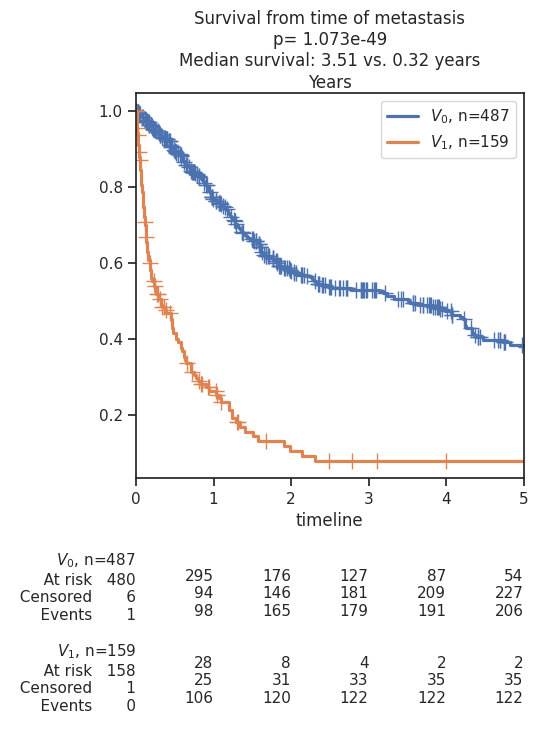

In [28]:
ax = plt.subplot(111)

kmf_0 = lifelines.KaplanMeierFitter()
kmf_0.fit(
    temp_df.loc[temp_df["group"] == "$V_0$"]["time"],
    event_observed=temp_df.loc[temp_df["group"] == "$V_0$"]["status"],
    label=f"$V_0$, n={temp_df.loc[temp_df['group'] == '$V_0$'].shape[0]}",
)
kmf_0.plot(
    ax=ax,
    ci_show=False,
    show_censors=True,
    linewidth=2.3,
)

kmf_1 = lifelines.KaplanMeierFitter()
kmf_1.fit(
    temp_df.loc[temp_df["group"] == "$V_1$"]["time"],
    event_observed=temp_df.loc[temp_df["group"] == "$V_1$"]["status"],
    label=f"$V_1$, n={temp_df.loc[temp_df['group'] == '$V_1$'].shape[0]}",
)
kmf_1.plot(ax=ax, ci_show=False, show_censors=True, linewidth=2.3)

_ = plt.xlim(0, 5)
# add at risk counts
lifelines.plotting.add_at_risk_counts(kmf_0, kmf_1, ax=ax)

res = lifelines.statistics.logrank_test(
    temp_df.loc[temp_df["group"] == "$V_0$"]["time"],
    temp_df.loc[temp_df["group"] == "$V_1$"]["time"],
    event_observed_A=temp_df.loc[temp_df["group"] == "$V_0$"]["status"],
    event_observed_B=temp_df.loc[temp_df["group"] == "$V_1$"]["status"],
)

_ = plt.xlabel("Years")
_ = plt.ylabel("Survival Probability")

_ = plt.title(
    f"Survival from time of metastasis\np={res.p_value: 0.3e}\n"
    f"Median survival: {round(kmf_0.median_survival_time_, 2)} vs. "
    f"{round(kmf_1.median_survival_time_, 2)} years"
)

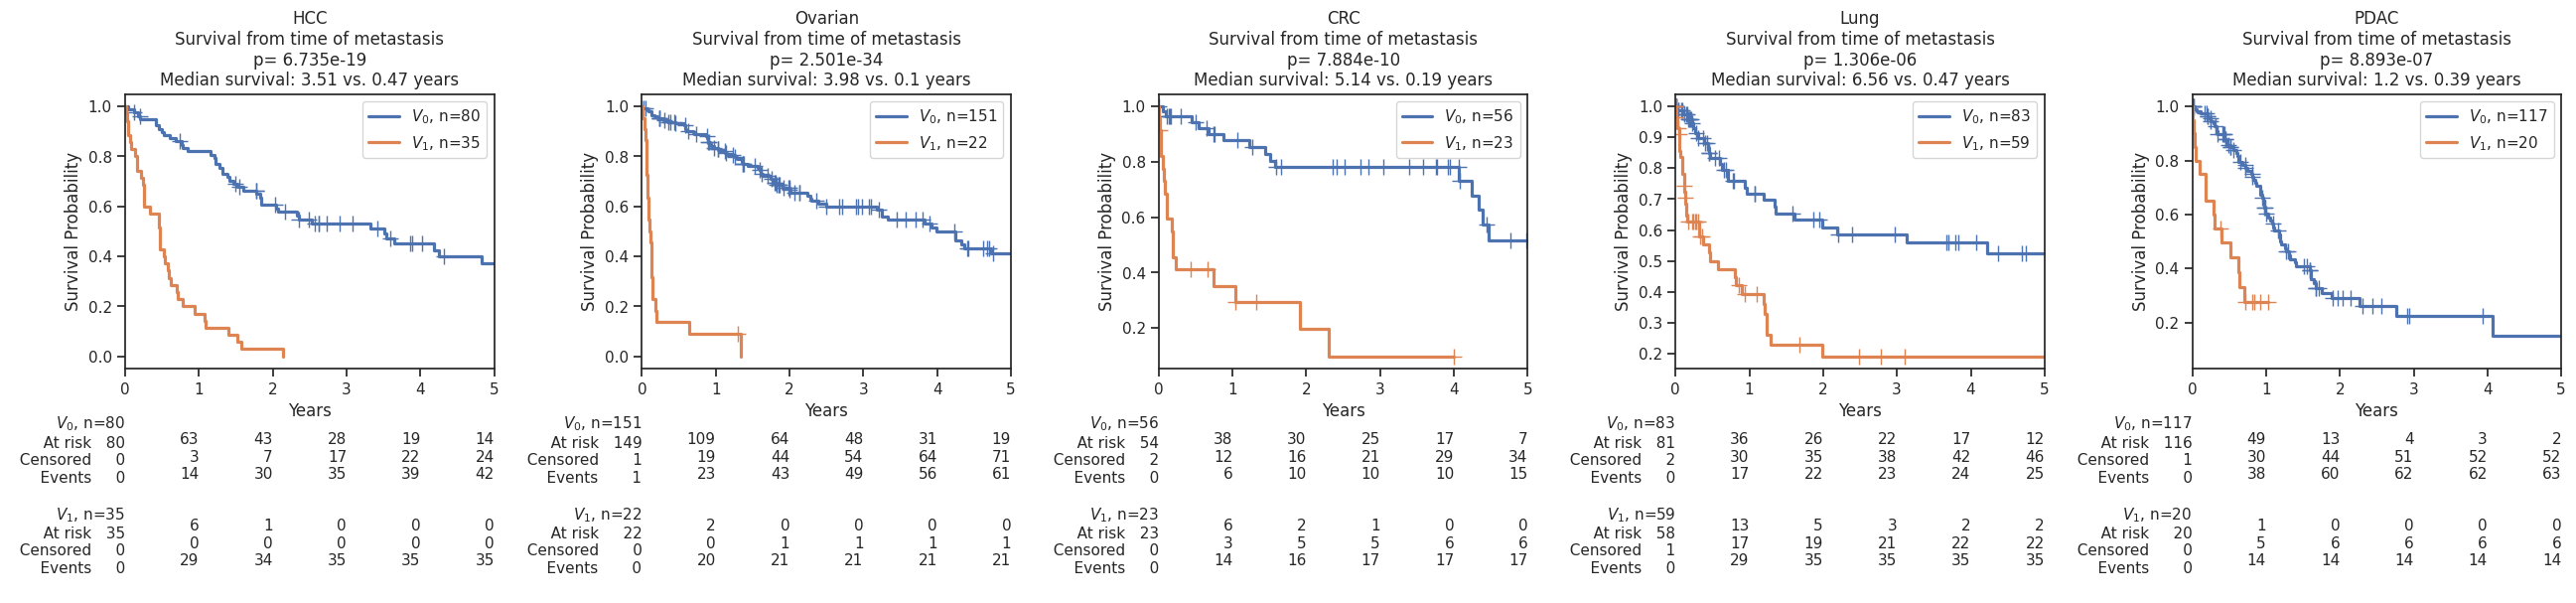

In [29]:
fig, ax = plt.subplots(1, 5, figsize=(5.22 * 5, 6.5))

for idx, cancer_type in enumerate(german_df["Cancer Type"].unique()):
    temp_df = []

    for data_dict in data:
        if (
            pd.isnull(data_dict["delta_to_mets"])
            or data_dict["cancer_type"] != cancer_type
        ):
            continue

        group = "$V_0$"

        if (
            not pd.isnull(data_dict["delta_to_involvement"])
            and data_dict["delta_to_involvement"] <= data_dict["delta_to_mets"] + 30
        ):
            group = "$V_1$"

        temp_df.append(
            {
                "time": (data_dict["time"] - data_dict["delta_to_mets"]),
                "status": data_dict["status"],
                "group": group,
            }
        )

    temp_df = pd.DataFrame(temp_df)

    temp_df["time"] = temp_df["time"] / 365

    kmf_0 = lifelines.KaplanMeierFitter()
    kmf_0.fit(
        temp_df.loc[temp_df["group"] == "$V_0$"]["time"],
        event_observed=temp_df.loc[temp_df["group"] == "$V_0$"]["status"],
        label=f"$V_0$, n={temp_df.loc[temp_df['group'] == '$V_0$'].shape[0]}",
    )
    kmf_0.plot(
        ax=ax[idx],
        ci_show=False,
        show_censors=True,
        linewidth=2.3,
    )

    kmf_1 = lifelines.KaplanMeierFitter()
    kmf_1.fit(
        temp_df.loc[temp_df["group"] == "$V_1$"]["time"],
        event_observed=temp_df.loc[temp_df["group"] == "$V_1$"]["status"],
        label=f"$V_1$, n={temp_df.loc[temp_df['group'] == '$V_1$'].shape[0]}",
    )
    kmf_1.plot(ax=ax[idx], ci_show=False, show_censors=True, linewidth=2.3)

    _ = plt.xlim(0, 5)
    # add at risk counts
    lifelines.plotting.add_at_risk_counts(
        kmf_0,
        kmf_1,
        ax=ax[idx],
        xticks=[0, 1, 2, 3, 4, 5],
        rows_to_show=["At risk", "Censored", "Events"],
    )

    res = lifelines.statistics.logrank_test(
        temp_df.loc[temp_df["group"] == "$V_0$"]["time"],
        temp_df.loc[temp_df["group"] == "$V_1$"]["time"],
        event_observed_A=temp_df.loc[temp_df["group"] == "$V_0$"]["status"],
        event_observed_B=temp_df.loc[temp_df["group"] == "$V_1$"]["status"],
    )

    _ = ax[idx].set_xlabel("Years")
    _ = ax[idx].set_ylabel("Survival Probability")

    _ = ax[idx].set_title(
        f"{cancer_type}\nSurvival from time of metastasis\np={res.p_value: 0.3e}\n"
        f"Median survival: {round(kmf_0.median_survival_time_, 2)} vs. "
        f"{round(kmf_1.median_survival_time_, 2)} years"
    )

    _ = ax[idx].set_xlim((0, 5))

_ = fig.tight_layout()

In [30]:
counts = {}

for it in data:
    if it["earliest_vessel"] not in counts:
        counts[it["earliest_vessel"]] = 0

    counts[it["earliest_vessel"]] += 1

counts = [(k, v) for k, v in counts.items()]
counts = sorted(counts, key=lambda x: x[1], reverse=True)
top_vessels = [it[0] for it in counts[1:6]]

In [31]:
counts[:6]

[(None, 852),
 ('Portal vein', 146),
 ('Pulmonary arteries', 79),
 ('Hepatic veins', 27),
 ('IVC', 24),
 ('Abdominal aorta', 24)]

In [32]:
temp_df = []

for data_dict in data:
    temp_df.append(
        {
            "pt": data_dict["pt"],
            "time": data_dict["time"],
            "status": data_dict["status"],
        }
    )

temp_df = pd.DataFrame(temp_df)
temp_df = to_long_format(
    temp_df,
    duration_col="time",
)

################## vessel involvement
cv = []

for data_dict in data:
    if (
        not pd.isnull(data_dict["delta_to_involvement"])
        and data_dict["delta_to_involvement"] <= 0
    ):
        this_vessel = "Other"

        if data_dict["earliest_vessel"] in top_vessels:
            this_vessel = f"{data_dict['earliest_vessel']} only"

        cv.append({"pt": data_dict["pt"], "time": 0, "vessel_involved": this_vessel})
    else:
        cv.append({"pt": data_dict["pt"], "time": 0, "vessel_involved": "None"})

    if (
        not pd.isnull(data_dict["delta_to_involvement"])
        and data_dict["delta_to_involvement"] > 0
    ):
        this_vessel = "Other"

        if data_dict["earliest_vessel"] in top_vessels:
            this_vessel = f"{data_dict['earliest_vessel']} only"

        cv.append(
            {
                "pt": data_dict["pt"],
                "time": data_dict["delta_to_involvement"],
                "vessel_involved": this_vessel,
            }
        )

cv = pd.DataFrame(cv, columns=["pt", "time", "vessel_involved"])

temp_df = add_covariate_to_timeline(
    temp_df, cv, id_col="pt", duration_col="time", event_col="status"
)

In [33]:
temp_df = pd.get_dummies(temp_df, columns=["vessel_involved"], drop_first=False)
temp_df = temp_df.drop(columns=["vessel_involved_None"])

# drop any rows with NaNs from dataset
temp_df = temp_df.dropna()

temp_df = temp_df.loc[
    ~((temp_df["start"] == temp_df["stop"]) & (temp_df["start"] == 0))
]

mod = CoxTimeVaryingFitter(penalizer=0.1)
_ = mod.fit(temp_df, id_col="pt", event_col="status", show_progress=True)

Iteration 1: norm_delta = 1.97e+00, step_size = 0.9500, log_lik = -3069.78046, newton_decrement = 5.78e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.24e-01, step_size = 0.9500, log_lik = -2975.49749, newton_decrement = 3.26e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 2.01e-01, step_size = 0.9500, log_lik = -2699.23401, newton_decrement = 1.67e+01, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.48e-02, step_size = 1.0000, log_lik = -2683.13239, newton_decrement = 1.07e-01, seconds_since_start = 0.1
Iteration 5: norm_delta = 4.47e-04, step_size = 1.0000, log_lik = -2683.02318, newton_decrement = 9.99e-05, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.42e-07, step_size = 1.0000, log_lik = -2683.02308, newton_decrement = 1.47e-10, seconds_since_start = 0.2
Convergence completed after 6 iterations.


/var/home/w/repos/spatialsherpa/env/lib64/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column vessel_involved_Abdominal aorta only have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['status'].astype(bool)
>>> print(df.loc[events, 'vessel_involved_Abdominal aorta only'].var())
>>> print(df.loc[~events, 'vessel_involved_Abdominal aorta only'].var())

A very low variance means that the column vessel_involved_Abdominal aorta only completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [34]:
mod.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
vessel_involved_Abdominal aorta only,3.872426,48.058859,0.254894,3.372844,4.372009,29.161340,79.202601,0.0,15.192314,3.976302e-52,170.748834
vessel_involved_Hepatic veins only,2.165385,8.717960,0.264112,1.647735,2.683035,5.195200,14.629433,0.0,8.198736,2.429287e-16,51.870317
vessel_involved_IVC only,3.019120,20.473276,0.259812,2.509898,3.528343,12.303678,34.067456,0.0,11.620405,3.245952e-31,101.281129
vessel_involved_Other,2.352592,10.512789,0.141175,2.075894,2.629291,7.971673,13.863931,0.0,16.664361,2.380190e-62,204.708465
vessel_involved_Portal vein only,2.502312,12.210688,0.108615,2.289431,2.715193,9.869318,15.107520,0.0,23.038419,1.921773e-117,387.723149
vessel_involved_Pulmonary arteries only,1.571140,4.812132,0.169693,1.238547,1.903733,3.450596,6.710901,0.0,9.258694,2.069476e-20,65.389296


In [35]:
temp_df = []

for data_dict in data:
    temp_df.append(
        {
            "pt": data_dict["pt"],
            "time": data_dict["time"],
            "status": data_dict["status"],
            "age": data_dict["age"],
            "sex": data_dict["sex"],
        }
    )

temp_df = pd.DataFrame(temp_df)
temp_df = to_long_format(
    temp_df,
    duration_col="time",
)

################## vessel involvement
cv = []

for data_dict in data:
    if (
        not pd.isnull(data_dict["delta_to_involvement"])
        and data_dict["delta_to_involvement"] <= 0
    ):
        this_vessel = "Other"

        if data_dict["earliest_vessel"] in top_vessels:
            this_vessel = f"{data_dict['earliest_vessel']} only"

        cv.append({"pt": data_dict["pt"], "time": 0, "vessel_involved": this_vessel})
    else:
        cv.append({"pt": data_dict["pt"], "time": 0, "vessel_involved": "None"})

    if (
        not pd.isnull(data_dict["delta_to_involvement"])
        and data_dict["delta_to_involvement"] > 0
    ):
        this_vessel = "Other"

        if data_dict["earliest_vessel"] in top_vessels:
            this_vessel = f"{data_dict['earliest_vessel']} only"

        cv.append(
            {
                "pt": data_dict["pt"],
                "time": data_dict["delta_to_involvement"],
                "vessel_involved": this_vessel,
            }
        )

cv = pd.DataFrame(cv, columns=["pt", "time", "vessel_involved"])

temp_df = add_covariate_to_timeline(
    temp_df, cv, id_col="pt", duration_col="time", event_col="status"
)

#################### resection and mets
for dict_var, cv_var in zip(
    ["delta_to_resection", "delta_to_mets"], ["resection", "mets"]
):
    cv = []

    for data_dict in data:
        if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] <= 0:
            cv.append({"pt": data_dict["pt"], "time": 0, cv_var: True})
        else:
            cv.append({"pt": data_dict["pt"], "time": 0, cv_var: False})

        if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] > 0:
            cv.append(
                {"pt": data_dict["pt"], "time": data_dict[dict_var], cv_var: True}
            )

    cv = pd.DataFrame(cv, columns=["pt", "time", cv_var])

    temp_df = add_covariate_to_timeline(
        temp_df, cv, id_col="pt", duration_col="time", event_col="status"
    )

In [36]:
temp_df = pd.get_dummies(temp_df, columns=["vessel_involved"], drop_first=False)
temp_df = temp_df.drop(columns=["vessel_involved_None"])

In [37]:
# drop any rows with NaNs from dataset
temp_df = temp_df.dropna()

mod = CoxTimeVaryingFitter(penalizer=0.1)
_ = mod.fit(temp_df, id_col="pt", event_col="status", show_progress=True)

Iteration 1: norm_delta = 1.58e+00, step_size = 0.9500, log_lik = -3041.37608, newton_decrement = 6.26e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.63e-01, step_size = 0.9500, log_lik = -2801.81311, newton_decrement = 2.26e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.03e-01, step_size = 0.9500, log_lik = -2601.14994, newton_decrement = 7.09e+00, seconds_since_start = 0.1
Iteration 4: norm_delta = 9.43e-03, step_size = 1.0000, log_lik = -2594.11938, newton_decrement = 5.81e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.62e-04, step_size = 1.0000, log_lik = -2594.06027, newton_decrement = 4.20e-05, seconds_since_start = 0.2
Iteration 6: norm_delta = 2.05e-07, step_size = 1.0000, log_lik = -2594.06023, newton_decrement = 2.57e-11, seconds_since_start = 0.2
Convergence completed after 6 iterations.


In [38]:
mod.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.019295,1.019482,0.003557,0.012324,0.026265,1.012400,1.026613,0.0,5.425138,5.790977e-08,24.041618
mets,0.830110,2.293572,0.079240,0.674804,0.985417,1.963647,2.678929,0.0,10.475954,1.114083e-25,82.892345
resection,-0.353652,0.702119,0.084466,-0.519203,-0.188101,0.594994,0.828531,0.0,-4.186899,2.827917e-05,15.109901
sex,0.159381,1.172784,0.077708,0.007075,0.311686,1.007100,1.365726,0.0,2.051008,4.026613e-02,4.634289
vessel_involved_Abdominal aorta only,3.525756,33.979439,0.257804,3.020469,4.031043,20.500895,56.319602,0.0,13.676096,1.410659e-42,139.024611
vessel_involved_Hepatic veins only,1.631357,5.110803,0.257591,1.126487,2.136226,3.084801,8.467420,0.0,6.333124,2.402465e-10,31.954765
vessel_involved_IVC only,2.807415,16.567043,0.267190,2.283733,3.331097,9.813247,27.969021,0.0,10.507200,8.003411e-26,83.369515
vessel_involved_Other,2.023177,7.562313,0.144068,1.740810,2.305545,5.701958,10.029638,0.0,14.043243,8.474463e-45,146.403642
vessel_involved_Portal vein only,2.115532,8.294001,0.110850,1.898270,2.332795,6.674340,10.306705,0.0,19.084626,3.388969e-81,267.315329


## individual cancer types

In [39]:
for cancer_type in set(german_df["Cancer Type"]):
    counts = {}

    for it in [pt for pt in data if pt["cancer_type"] == cancer_type]:

        if it["earliest_vessel"] not in counts:
            counts[it["earliest_vessel"]] = 0

        counts[it["earliest_vessel"]] += 1

    counts = [(k, v) for k, v in counts.items()]
    counts = sorted(counts, key=lambda x: x[1], reverse=True)
    top_vessels = [it[0] for it in counts[1:] if it[1] >= 10]

    print(
        f"###############################\n\n"
        f"{cancer_type}\n"
        f"Top vessels: {', '.join(top_vessels)}\n"
    )

    for k, v in counts[:6]:
        print(f"{k}: {v}")

    temp_df = []

    for data_dict in [pt for pt in data if pt["cancer_type"] == cancer_type]:

        this_pt_dict = {
            "pt": data_dict["pt"],
            "time": data_dict["time"],
            "status": data_dict["status"],
        }

        temp_df.append(this_pt_dict)

    temp_df = pd.DataFrame(temp_df)
    temp_df = to_long_format(
        temp_df,
        duration_col="time",
    )

    ################## vessel involvement
    cv = []

    for data_dict in [pt for pt in data if pt["cancer_type"] == cancer_type]:
        if (
            not pd.isnull(data_dict["delta_to_involvement"])
            and data_dict["delta_to_involvement"] <= 0
        ):
            this_vessel = "Other"

            if data_dict["earliest_vessel"] in top_vessels:
                this_vessel = f"{data_dict['earliest_vessel']} only"

            cv.append(
                {"pt": data_dict["pt"], "time": 0, "vessel_involved": this_vessel}
            )
        else:
            cv.append({"pt": data_dict["pt"], "time": 0, "vessel_involved": "None"})

        if (
            not pd.isnull(data_dict["delta_to_involvement"])
            and data_dict["delta_to_involvement"] > 0
        ):
            this_vessel = "Other"

            if data_dict["earliest_vessel"] in top_vessels:
                this_vessel = f"{data_dict['earliest_vessel']} only"

            cv.append(
                {
                    "pt": data_dict["pt"],
                    "time": data_dict["delta_to_involvement"],
                    "vessel_involved": this_vessel,
                }
            )

    cv = pd.DataFrame(cv, columns=["pt", "time", "vessel_involved"])

    temp_df = add_covariate_to_timeline(
        temp_df, cv, id_col="pt", duration_col="time", event_col="status"
    )

    #################### resection and mets
    for dict_var, cv_var in zip(
        ["delta_to_resection", "delta_to_mets"], ["resection", "mets"]
    ):
        cv = []

        for data_dict in [pt for pt in data if pt["cancer_type"] == cancer_type]:
            if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] <= 0:
                cv.append({"pt": data_dict["pt"], "time": 0, cv_var: True})
            else:
                cv.append({"pt": data_dict["pt"], "time": 0, cv_var: False})

            if not pd.isnull(data_dict[dict_var]) and data_dict[dict_var] > 0:
                cv.append(
                    {"pt": data_dict["pt"], "time": data_dict[dict_var], cv_var: True}
                )

        cv = pd.DataFrame(cv, columns=["pt", "time", cv_var])

        temp_df = add_covariate_to_timeline(
            temp_df, cv, id_col="pt", duration_col="time", event_col="status"
        )

    temp_df = pd.get_dummies(temp_df, columns=["vessel_involved"], drop_first=False)
    temp_df = temp_df.drop(columns=["vessel_involved_None"])
    # drop any rows with NaNs from dataset
    temp_df = temp_df.dropna()

    mod = CoxTimeVaryingFitter(penalizer=0.1)
    _ = mod.fit(temp_df, id_col="pt", event_col="status", show_progress=False)

    display(mod.summary)

    print(len(temp_df["pt"].unique()), "patients in this cancer type")

###############################

PDAC
Top vessels: Portal vein, Superior mesenteric artery

None: 149
Portal vein: 49
Superior mesenteric artery: 18
Hepatic veins: 8
IVC: 6
Superior mesenteric vein: 6


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mets,0.603714,1.828898,0.175210,0.260308,0.947120,1.297329,2.578274,0.0,3.445650,5.696876e-04,10.777541
resection,-0.181152,0.834308,0.177159,-0.528377,0.166072,0.589561,1.180659,0.0,-1.022542,3.065242e-01,1.705927
vessel_involved_Other,2.103080,8.191358,0.250220,1.612658,2.593501,5.016128,13.376521,0.0,8.404937,4.280907e-17,54.374861
vessel_involved_Portal vein only,2.062738,7.867483,0.208380,1.654321,2.471155,5.229530,11.836108,0.0,9.898940,4.207089e-23,74.331524
vessel_involved_Superior mesenteric artery only,1.446311,4.247417,0.390786,0.680385,2.212238,1.974637,9.136136,0.0,3.701031,2.147253e-04,12.185220


250 patients in this cancer type
###############################

Ovarian
Top vessels: Abdominal aorta, Portal vein, IVC

None: 177
Abdominal aorta: 18
Portal vein: 17
IVC: 10
Superior mesenteric artery: 5
Common iliac vein: 4


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mets,0.774854,2.170275,0.212957,0.357466,1.192241,1.429702,3.294456,0.0,3.638551,2.741763e-04,11.832608
resection,-0.632431,0.531299,0.214130,-1.052118,-0.212743,0.349197,0.808364,0.0,-2.953485,3.142076e-03,8.314066
vessel_involved_Abdominal aorta only,3.448105,31.440756,0.339819,2.782073,4.114137,16.152469,61.199382,0.0,10.146901,3.420530e-24,77.952054
vessel_involved_IVC only,2.631229,13.890833,0.438283,1.772210,3.490248,5.883843,32.794084,0.0,6.003493,1.931172e-09,28.947876
vessel_involved_Other,3.061405,21.357535,0.270557,2.531123,3.591687,12.567606,36.295242,0.0,11.315191,1.103614e-29,96.193679
vessel_involved_Portal vein only,2.821225,16.797414,0.316780,2.200347,3.442103,9.028148,31.252600,0.0,8.905940,5.293558e-19,60.712396


250 patients in this cancer type
###############################

CRC
Top vessels: Portal vein

None: 203
Portal vein: 10
Hepatic veins: 9
Pulmonary arteries: 6
IVC: 5
Pulmonary veins: 5


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mets,0.444082,1.559058,0.230142,-0.006987,0.895151,0.993037,2.447705,0.0,1.929603,5.365610e-02,4.220114
resection,-0.065398,0.936695,0.218464,-0.493580,0.362785,0.610437,1.437326,0.0,-0.299352,7.646716e-01,0.387088
vessel_involved_Other,2.215634,9.167222,0.289109,1.648991,2.782277,5.201729,16.155772,0.0,7.663666,1.806999e-14,45.653397
vessel_involved_Portal vein only,1.776662,5.910097,0.445909,0.902697,2.650627,2.466246,14.162921,0.0,3.984363,6.766146e-05,13.851306


243 patients in this cancer type
###############################

HCC
Top vessels: Portal vein

None: 168
Portal vein: 69
Hepatic veins: 8
Hepatic veins + Portal vein: 4
IVC: 1


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mets,1.013890,2.756303,0.156832,0.706505,1.321275,2.026896,3.748198,0.0,6.464821,1.014191e-10,33.198952
resection,-0.910357,0.402381,0.180604,-1.264335,-0.556379,0.282427,0.573281,0.0,-5.040620,4.640256e-07,21.039292
vessel_involved_Other,1.474405,4.368435,0.318710,0.849745,2.099064,2.339051,8.158533,0.0,4.626169,3.724909e-06,18.034363
vessel_involved_Portal vein only,1.754308,5.779445,0.184048,1.393580,2.115036,4.029247,8.289881,0.0,9.531778,1.546123e-21,69.131835


250 patients in this cancer type
###############################

Lung
Top vessels: Pulmonary arteries

None: 155
Pulmonary arteries: 71
Pulmonary arteries + Pulmonary veins: 4
Pulmonary veins: 3
IVC: 2
Aortic arch: 2


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mets,1.024000,2.784309,0.194477,0.642832,1.405168,1.901859,4.076211,0.0,5.265400,1.398842e-07,22.769264
resection,-0.297921,0.742360,0.231984,-0.752602,0.156759,0.471139,1.169714,0.0,-1.284232,1.990609e-01,2.328718
vessel_involved_Other,1.716167,5.563163,0.281208,1.165009,2.267325,3.205951,9.653542,0.0,6.102832,1.042054e-09,29.837922
vessel_involved_Pulmonary arteries only,1.182661,3.263047,0.215363,0.760558,1.604765,2.139469,4.976689,0.0,5.491480,3.985788e-08,24.580560


249 patients in this cancer type


## Frequencies of vessel involvement by cancer type

In [40]:
counts = {}

for idx, row in german_df.iterrows():
    cancer_type = row["Cancer Type"]

    vessels = []

    for vessel_idx in range(1, 5):
        vessel_col = f"Vessel {vessel_idx} involvement"
        if pd.notna(row[vessel_col]) and row[vessel_col] == 1:
            if pd.isnull(row[f"Vessel {vessel_idx} type"]):
                continue

            vessels.append(row[f"Vessel {vessel_idx} type"])

    for vessel in vessels:
        id = (cancer_type, vessel)

        if id not in counts:
            counts[id] = 0

        counts[id] += 1

In [41]:
unique_cancer_types = list(set([it[0] for it in counts]))
unique_vessels = list(set([it[1] for it in counts]))

heatmap = np.zeros((len(unique_cancer_types), len(unique_vessels)), dtype=int)

for (cancer_type, vessel), count in counts.items():
    cancer_type_idx = unique_cancer_types.index(cancer_type)
    vessel_idx = unique_vessels.index(vessel)
    heatmap[cancer_type_idx, vessel_idx] = count

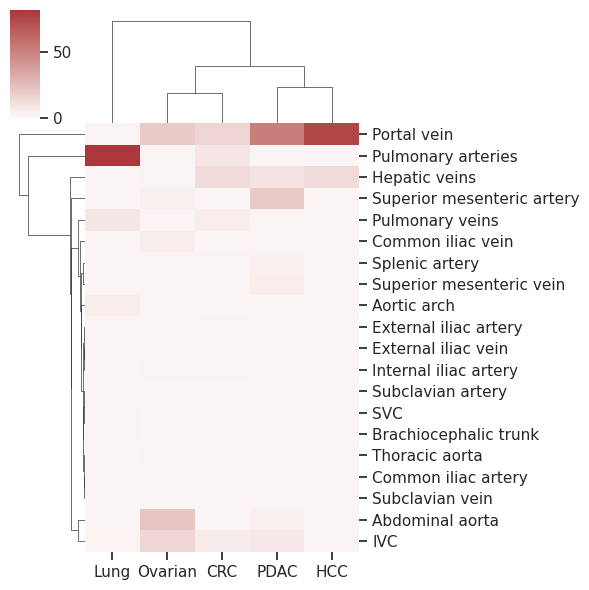

In [42]:
p = sns.clustermap(
    heatmap.T,
    cmap="vlag",
    center=0,
    figsize=(6, 6),
    yticklabels=unique_vessels,
    xticklabels=unique_cancer_types,
)

## Time to detection


In [43]:
vals = []
labs = []

for _idx, row in german_df.iterrows():
    vessel_times = []

    for vessel in range(1, 5):
        vessel_col = f"Vessel {vessel} involvement"

        if row[vessel_col] == 1:
            imaging_time_cols = []

            for imaging_idx in range(1, 10):
                this_imaging_time_col = f"Vessel {vessel} Imaging time {imaging_idx} time to involvement (days)"
                if this_imaging_time_col in row:
                    imaging_time_cols.append(this_imaging_time_col)

            final_imaging_time_col = (
                f"Vessel {vessel} LAST AVAILABLE STUDY time to involvement (days)"
            )

            if final_imaging_time_col in row:
                imaging_time_cols.append(final_imaging_time_col)

            involvement_times = [
                row[it] for it in imaging_time_cols if pd.notnull(row[it])
            ]
            earliest_involvement = min(involvement_times)

            vessel_times.append((row[f"Vessel {vessel} type"], earliest_involvement))

    earliest_vessel = None

    if len(vessel_times) > 0:
        min_time = min([it[1] for it in vessel_times])

        vals.append(min_time / 365.25)
        labs.append(row["Cancer Type"])

all_cancer_types = list(set(labs))

dists = [[] for _ in all_cancer_types]

for val, lab in zip(vals, labs):
    dists[all_cancer_types.index(lab)].append(val)

kruskal_result = kruskal(*dists)

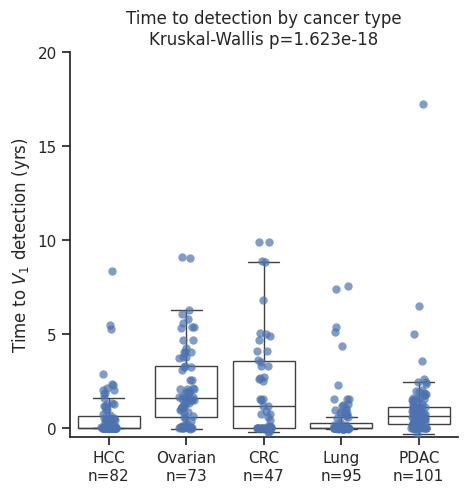

In [44]:
p = sns.boxplot(
    x=labs, y=vals, saturation=0.8, color="white", fliersize=0, **boxplot_props
)
b = sns.stripplot(
    x=labs,
    y=vals,
    alpha=0.7,
    size=6,
)
_ = plt.ylabel("Time to $V_1$ detection (yrs)")

_ = plt.title(
    f"Time to detection by cancer type\nKruskal-Wallis p={kruskal_result.pvalue:.3e}"
)

_ = plt.ylim((-0.5, 20))
# make yticks linspace
yticks = np.linspace(0, 20, 5)
_ = plt.yticks(yticks)

xticklabels = plt.xticks()[1]
xticklabels = [it.get_text() for it in xticklabels]

# set xticks
x_tick_coords = []
x_tick_labs = []

groups = all_cancer_types

for idx, group in enumerate(xticklabels):
    group_split = "\n".join(group.split())
    x_tick_coords.append(idx)
    x_tick_labs.append(
        f"{group_split}\nn={len([v for idx, v in enumerate(vals) if labs[idx] == group])}"
    )

_ = plt.xticks(x_tick_coords, x_tick_labs)
sns.despine()